<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/root_finding/MultipleRoots_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [524]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import time
from functools import partial
import numpy as np

look into using vmap instead of repeat and some of these other weird processes

In [525]:
#@jax.jit
def poop():
  y = jnp.array([[1, 2, 3],[4, 5, 6]])
  p = jnp.array([[1, 2, 3],[3, 2, 1]])
  # for some reason you have to flatten the array when repeating
  final = jnp.repeat(y, p, total_repeat_length=12)
  final = final.reshape((2,6))
  return final

print(poop())

[[1 2 2 3 3 3]
 [4 4 4 5 5 6]]


In [526]:
@jax.jit
def signDistance(t):
  # derivative must be upper bounded by 1 since its supposed to be a signed distance function
  #return 3*jnp.power(t,2) + t + 1
  #return (t-0.01)*(t-0.02)*(t-0.98)*(t-0.99)
  return jnp.sin(t)

In [527]:
@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts'])
def createQuadrature(uni_cuts, quad_cuts, p0, p1):
  lb = jnp.zeros(p0.shape)
  ub = jnp.ones(p1.shape)
  t0 = jnp.linspace(lb, ub, uni_cuts, axis=0)

  v0 = jnp.abs(signDistance(p0 + t0 * (p1 - p0)))
  # quad_cuts should be greater than or equal to uni_cuts? not true?
  
  # smart variation
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = (p1 - p0) / (2 * (uni_cuts - 1))
  n_close = jnp.count_nonzero(v0 < threshold, axis=0)
  
  spacing_amount = ((quad_cuts - uni_cuts) // n_close).astype(int) + 1
  spacing_value = uni_space / (spacing_amount)

  h = jnp.where(v0 < threshold, spacing_amount, 1)
  lol = jnp.where(v0 < threshold, spacing_value, uni_space)

  extra = quad_cuts % n_close
  h = h.at[-1].add(extra)

  '''
  # experimental variation
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = uni_space / 2
  n_close = jnp.count_nonzero(v0 < threshold)
  lol = jnp.where(v0 < threshold, v0, 0)
  lol = 1 / lol
  lol = jnp.where(jnp.isinf(lol), 0, lol)
  lol = lol / jnp.sum(lol)
  # smooth the distribution at this point?
  lol = lol * (quad_cuts - uni_cuts)
  lol = jnp.floor(lol).astype(int)
  lol += 1
  extra = jnp.sum(lol) % n_close
  lol = lol.at[-1].add(extra)
  h = uni_space * 1 / lol
  '''

  lol2 = jnp.ravel(lol, order='F')
  h2 = jnp.ravel(h, order='F')
  xd = jnp.repeat(lol2, h2, total_repeat_length=quad_cuts * len(lb))
  xd = jnp.reshape(xd, (quad_cuts, len(lb)), order='F')
  xd = jnp.cumsum(xd, axis=0)
  xd -= uni_space / 2
  #xd += lb

  return xd

In [528]:
@jax.jit
def rootIsolate(key, quadrature, p0, p1):
  # don't pick roots on the wrong side of the line?
  # maybe we should be doing the whole line at once?
  # some way to avoid sorting?

  # find the roots
  v = signDistance(p0 + quadrature * (p1 - p0))
  v = jnp.where(v > 0, 1, -1)
  roots = v[:-1] + v[1:]

  # check how many roots
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)
  print("number of roots found:", n_zeros)

  # randomly pick a root
  minvals = jnp.array(jnp.size(quadrature, 1) * [0])
  random_indices = jrandom.randint(key, (1,jnp.size(quadrature, 1)), minval=minvals, maxval=n_zeros)
  
  roots = jnp.where(roots == 0, 0, 1)
  all_root_indices = jnp.argsort(roots, axis=0)
  root_indices = jnp.take_along_axis(all_root_indices, random_indices, axis=0)

  lb = jnp.take_along_axis(quadrature, root_indices, axis=0)
  ub = jnp.take_along_axis(quadrature, root_indices+1, axis=0)
  
  # return the roots interval
  return lb, ub

In [529]:
@jax.jit
def bisection(p0, p1, rootSteps, dir):
  current = jnp.zeros((1, jnp.size(p0, 1)))

  def bisectionStep(i, current):
    next = current + jnp.power(0.5, i+1)
    dist1 = signDistance(p0 + dir * next * (p1 - p0))
    dist2 = signDistance(p0 + dir * current * (p1 - p0))
    return jnp.where(dist1 * dist2 > 0, next, current)

  current = lax.fori_loop(0, rootSteps, bisectionStep, current)
  
  return p0 + dir * current * (p1 - p0)

In [547]:
%%time
key = jrandom.PRNGKey(int(time.time()))

uni_cuts = 10
quad_cuts = 20
p0 = jnp.array([0, 0])
p1 = jnp.array([10, 5])

# must always have more uni_cuts then there are roots
quadrature_t = createQuadrature(uni_cuts, quad_cuts, p0, p1)
t1, t2 = rootIsolate(key, quadrature_t, p0, p1)
root = bisection(p0 + t1 * (p1 - p0), 
                 p0 + t2 * (p1 - p0), 
                 5, dir=1)

# use "t, t2, dir" to find the sign of the normal
print('root:', root)
print('signDistance(root):', signDistance(root))

root: [[6.273148  3.1394675]]
signDistance(root): [[-0.01003708  0.00212517]]
CPU times: user 8.86 ms, sys: 0 ns, total: 8.86 ms
Wall time: 11.5 ms


# Graphing

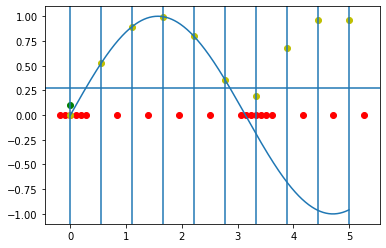

In [532]:
sample = 1
t = jnp.linspace(p0[sample], p1[sample], 500)
plt.plot(t, signDistance(t))

plt.scatter(root[0,sample], 0.1, c='g')


quadrature_zeros = jnp.zeros(len(quadrature_t))
quadrature = p0 + quadrature_t * (p1 - p0)
plt.scatter(quadrature[:,sample], quadrature_zeros, c='r')


t0 = jnp.linspace(p0[sample], p1[sample], uni_cuts)
v0 = jnp.abs(signDistance(t0))
threshold = (p1[sample] - p0[sample]) / (uni_cuts - 1)
plt.scatter(t0, v0, c='y')
plt.axhline(threshold / 2, linestyle='-')
for t in t0:
  plt.axvline(t, linestyle='-')
